# NTDS 2017 Project
## Exploring the Crunchbase Dataset to detect high potential startups
Timothée Bronner, Alexandre Carlier, Saleh Gholam Zadeh & Clément Luneau

<img src="https://pbs.twimg.com/profile_images/775382507223076865/H2TUGumm.jpg" style="height:180px; display:inline-block; margin-left:40px;" />
<img src="http://www.livemint.com/rf/Image-621x414/LiveMint/Period1/2016/02/20/Photos/startups-k6aG--621x414@LiveMint.jpg" style="height:180px; display:inline-block; margin-left: 10px; margin-top:0" />

### Abstract

In this project, we analyze the 2013 Snapshot dataset of Crunchbase, which contains more than 200,000 startup profiles along with 80,000 investments. By analyzing data of previous years, our ultimate goal is to find out some patterns that could predict which startups will become the next unicorn and hence to give advice to venture capitalists.

### APIs used

* [Crunchbase](https://data.crunchbase.com/docs/2013-snapshot) : to get the full 2013 Crunchbase database.
* [Intrinio](https://intrinio.com/data-tag/marketcap) : to get market capitalizations of specific companies.

### Libraries used for this proje

We will use following libraries:
* Pandas, Numpy, Scipy, Matplotlib (as usual).
* Graph Tool: during the project, we moved from NetworkX to Graph Tool as drawing graphs with NetworkX was too time consuming.
* Basemap: for plotting companies on a map.
* PyGSP: for signal filtering on graphs.
* tqdm: a smart progress meter

### Installation guide
- For standard libraries, run `pip install -r requirements.txt` in your terminal to install the dependencies.
- Graph-tool is a C++ library wrapped in Python and has many C++ dependencies (Boost, CGAL, ...), thus it cannot be installed through `pip`. See the instructions [here](https://git.skewed.de/count0/graph-tool/wikis/installation-instructions) on how to install it.

### Importing the data
We downloaded the 2013 Snapshot through the [Crunchbase API](https://data.crunchbase.com/docs/2013-snapshot). A registration is required to get the key and the data are SQL databases. Therefore, we provide the whole dataset in CSV on [Google Drive](https://drive.google.com/drive/folders/1RrcUJ5EWR5tJ5WTVkW2nJENWPkk8LNVD?usp=sharing).
The Google Drive also includes our processed data.

Download link: https://drive.google.com/drive/folders/1RrcUJ5EWR5tJ5WTVkW2nJENWPkk8LNVD?usp=sharing

To have the same architecture as ours, please put the files in a folder called `data` at the root directory.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from graph_tool.all import *
from mpl_toolkits.basemap import Basemap
from pygsp import graphs, filters, plotting
import helpers

plotting.BACKEND = "matplotlib"

In [2]:
warnings.filterwarnings('ignore')

### Exploratory Data Analysis

In [3]:
#Loading CSV files
objects = pd.read_csv("data/cb_objects.csv", index_col=0, low_memory=False)
investments = pd.read_csv("data/cb_investments.csv", index_col=0)
funding_rounds = pd.read_csv("data/cb_funding_rounds.csv", index_col=0)
ipos = pd.read_csv("data/cb_ipos.csv", index_col=0)
acquisitions = pd.read_csv("data/cb_acquisitions.csv", index_col=0)

objects.set_index("id", inplace=True)
funding_rounds.set_index("funding_round_id", inplace=True)
ipos.set_index("object_id", inplace=True)

The object database comprises Persons (Angel investors), Companies and Financial Organizations. For our project we will only look at the companies.

In [4]:
objects["entity_type"].value_counts()

Person          226708
Company         196553
Product          27738
FinancialOrg     11652
Name: entity_type, dtype: int64

In [5]:
companies = objects[objects["entity_type"] == "Company"]

In [6]:
del objects

In [7]:
print("Companies are classified into {} categories".format(len(companies["category_code"].value_counts())))

Companies are classified into 42 categories


There are too many categories (42 in total), so we merged them in parent categories to have a better insight.

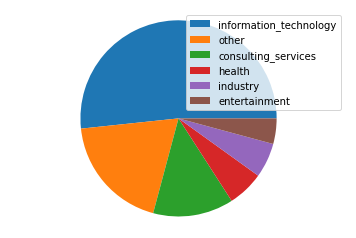

In [8]:
companies["category_code"] = helpers.merge_categories(companies["category_code"])
helpers.plot_categories(companies)

#### Analyzing the distribution of the total amount raised by companies

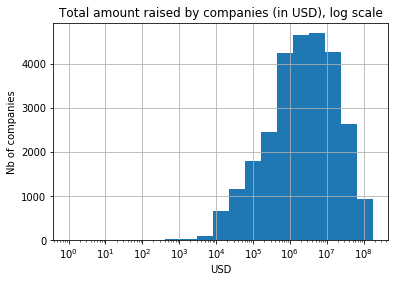

In [9]:
companies["funding_total_usd"].hist(bins=np.exp(range(20)))
plt.title("Total amount raised by companies (in USD), log scale")
plt.xlabel('USD')
plt.ylabel('Nb of companies')
plt.xscale("log")

### Adding data to companies.csv

Some useful data about companies aren't available in the objects database, so we explored the other available datasets to add those features (e.g. return on investment) to `companies.csv`.

* Given the country and the city of a company, we can get its latitude and longitude via the Google Maps Geocoding API.

In [ ]:
"""
# Using this function computes the latitude and longitude of every company of the database (over 190,000 entries).
# This can take a while. We suggest to directly use our saved database.

companies, locations = helpers.geocode_companies(companies)
companies.to_csv("data/companies.csv")
locations.to_csv("data/locations.csv")
"""

* In the remaining part, we will also need the ROI (*return on investment*) of companies that have been acquired. Let's do it here:

In [11]:
helpers.compute_ROI(companies, acquisitions)

100%|██████████| 9562/9562 [00:02<00:00, 3723.71it/s]


In [12]:
#Loading our saved database with everything needed.

companies = pd.read_csv("data/companies.csv")
companies.set_index("id", inplace=True)

Let's look at the locations of the companies:

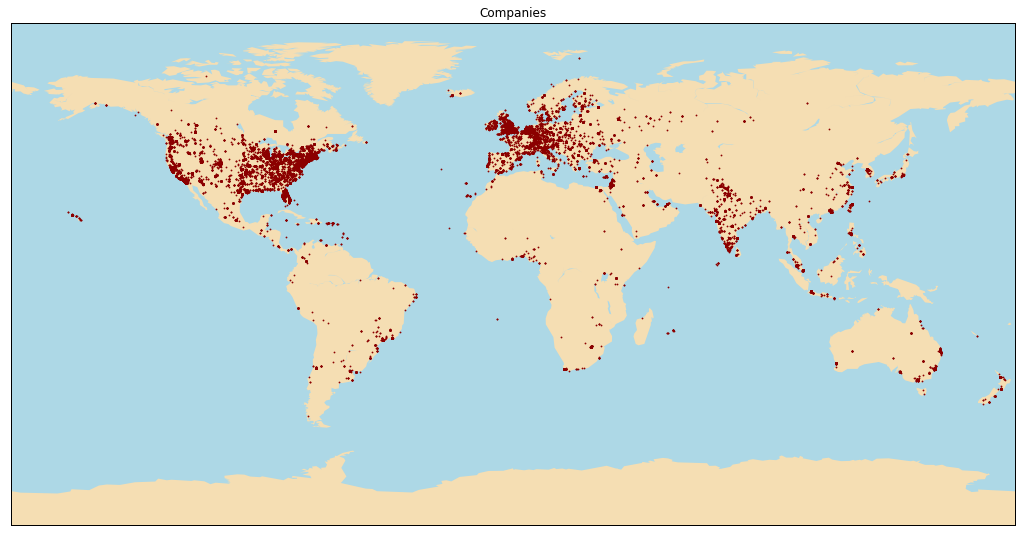

In [13]:
helpers.draw_map(companies["lat"], companies["lng"], title="Companies")

More than half of the companies are US-based. Below the detailed distribution of countries:

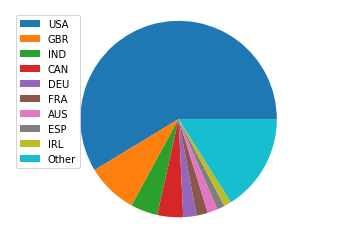

In [14]:
helpers.plot_country(companies)

### Data cleaning

We keep only companies for which we have information such as total funding, location and who have raised a significant amount of money. To be sure we'll be able to manage the amount of data, we set a threshold on the funding of the companies. The latter was determined by a process of trial and error.

In [15]:
threshold = 10e6 # Amount in USD
trimmed_investments = helpers.trim_investments(investments, companies, threshold)
trimmed_investments.to_csv("data/trimmed_investments.csv")
print("Before trimming there are " + str(len(investments)) + " investments.")
print("After trimming " + str(len(trimmed_investments)) + " investments are remaining.")

Before trimming there are 80902 investments.
After trimming 40963 investments are remaining.


In [16]:
del investments

### Building the Investment Graph

We start by creating a bipartite graph with investors and companies as nodes. An investor is linked to a company if it has invested into this company. Those links are obtained by going through the trimmed investments dataset.

In [17]:
bipartite_investments_graph, _ = helpers.build_bipartite_investments_graph(trimmed_investments, funding_rounds)

From the bipartite investments graph, we build a graph comprising only the companies. Two companies are connected if they have a common investor. The weight of the edge is the number of common investors. This is the graph will work on from now.

In [18]:
g = helpers.build_investments_graph(trimmed_investments, companies, funding_rounds)
del bipartite_investments_graph
g

<Graph object, undirected, with 6034 vertices and 473465 edges at 0x7f014c72b410>

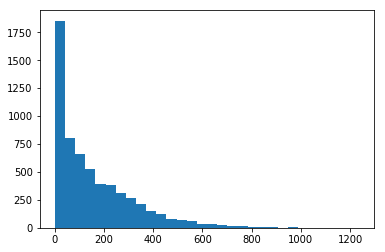

In [19]:
degrees = g.get_out_degrees(g.get_vertices())
plt.hist(degrees, bins=30);

### Spectral analysis

We compute the graph Laplacian and its 1000 smallest eigenvalues.

In [20]:
L = graph_tool.spectral.laplacian(g, normalized=True)

In [21]:
eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(L,k=100,which='SM', maxiter=100000*L.shape[0])

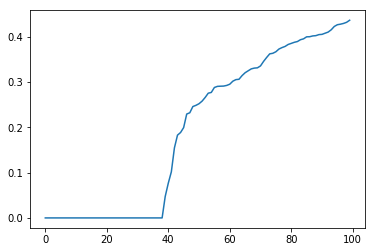

In [22]:
plt.plot(eigenvalues);

In [23]:
print(eigenvalues[38:40])

[1.94363311e-15 4.71980974e-02]


The 39 smallest eigenvalues are zero and the $40^{th}$ smallest eigenvalue is clearly nonzero. Therefore, the graph g is made of 40 connected components. As we will see most of the vertices are in one giant component.

We use the eigenvectors associated to the $40^{th}$ and $41^{th}$ eigenvalues as coordinates for the vertices in the graph:

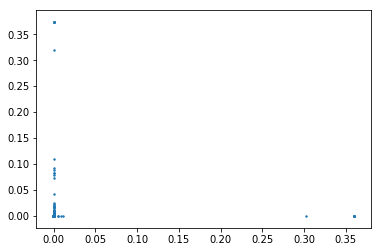

In [24]:
plt.scatter(eigenvectors[:,39],eigenvectors[:,40],s=2.)

We could not get any meaningful information out of this plot. Most of the 6034 companies are located in a dense region around  the origin.

## Working on the giant component

We keep only the giant component of the graph g.

In [25]:
l = graph_tool.topology.label_largest_component(g, directed=None)
g_gc = graph_tool.GraphView(g, vfilt=l)
g_gc.purge_vertices()
print("The giant component has {} vertices and {} edges.".format(g_gc.num_vertices(), g_gc.num_edges()))

The giant component has 5933 vertices and 473351 edges.


In [26]:
del g

In [27]:
lat = [g_gc.vp.lat[v] for v in g_gc.vertices()]
lng = [g_gc.vp.lng[v] for v in g_gc.vertices()]

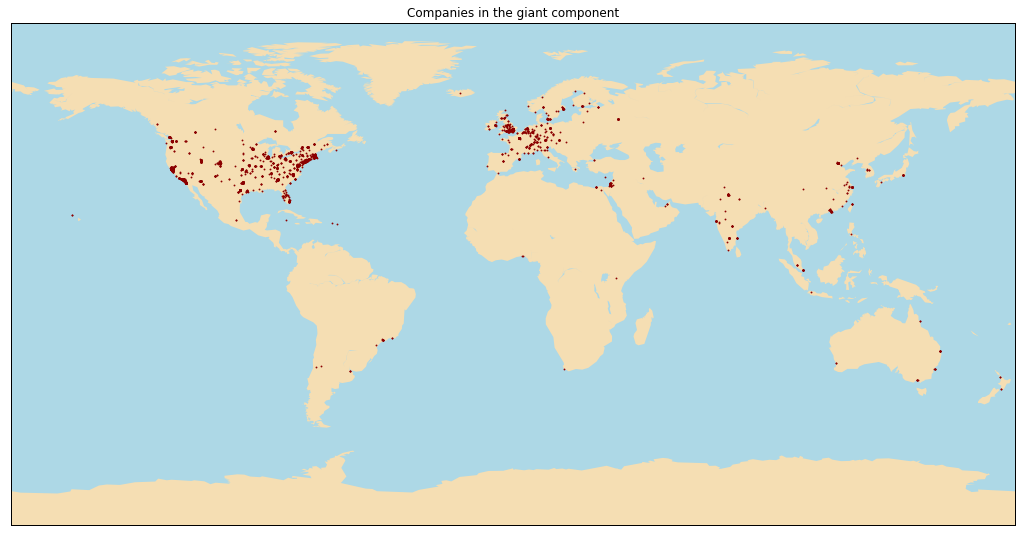

In [28]:
helpers.draw_map(lat, lng, title="Companies in the giant component", size=2.8)

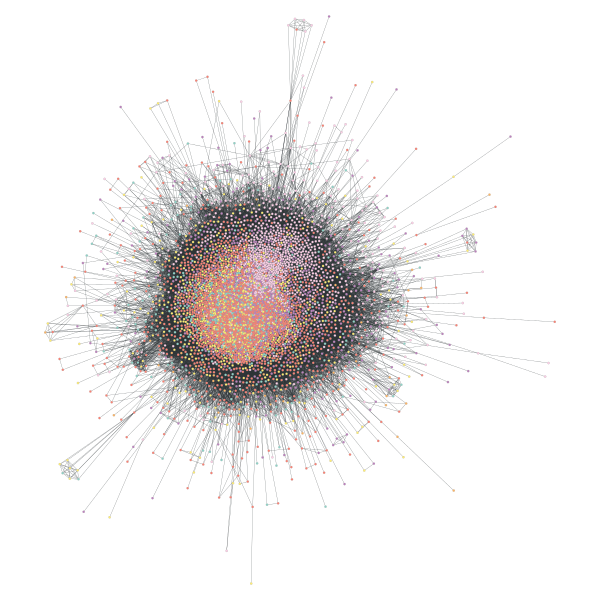

In [29]:
graph_draw(g_gc, vertex_fill_color=g_gc.vp.category_code);

### Diameter

The giant component is far from being sparse but it is not complete either, as we can see by computing the diameter:

In [30]:
dist_map = graph_tool.topology.shortest_distance(g_gc)
diameter = np.max([np.max(dist_map[v]) for v in g_gc.vertices()])
print("Diameter: {}".format(diameter))

Diameter: 8


## Signal filtering on the graph
We want to use signal filtering on the giant component to predict good investments (in the sense of a high return on investment). For that we need the PyGSP library.

In [31]:
adjMatrix = graph_tool.spectral.adjacency(g_gc)
ROI_gc = np.array([g_gc.vp.ROI[vertex] for vertex in g_gc.vertices()])
vertex_ids_gc = np.array([g_gc.vp.vertex_id[vertex] for vertex in g_gc.vertices()])
ROI_gc[np.isnan(ROI_gc)] = -1.

In [ ]:
"""
indices, = np.nonzero(ROI_gc >= 0)
idxHighestROI = indices[np.argmax(ROI_gc[indices])]
print("The index of the vertex corresponding to the company with the highest ROI is " + str(idxHighestROI) + ".")
print("The corresponding ROI is " + str(g_gc.vp.ROI[g_gc.vertex(idxHighestROI)]) + " .")
print("Company name: {}".format(companies.loc[g_gc.vp.vertex_id[idxHighestROI]]["name"]))
"""

In [33]:
#sp.sparse.save_npz('data/weights', A)
#np.save('data/ROI',ROI_gc)
#np.save("data/vertex_ids", vertex_ids_gc)

In [34]:
#W = sp.sparse.load_npz("data/weights.npz")
#ROI = np.load("data/ROI.npy")
#vertex_ids = np.load("data/vertex_ids.npy")

In [35]:
G = graphs.Graph(adjMatrix)

In [36]:
del adjMatrix

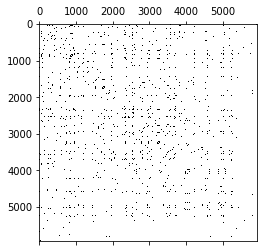

In [37]:
plt.spy(G.W.todense());

In [38]:
G.compute_laplacian("normalized")

In [39]:
G.compute_fourier_basis()

2018-01-22 22:12:59,830:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (5933 x 5933) may take some time.


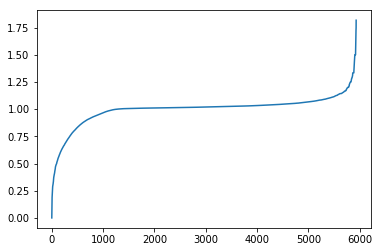

In [40]:
plt.plot(G.e);

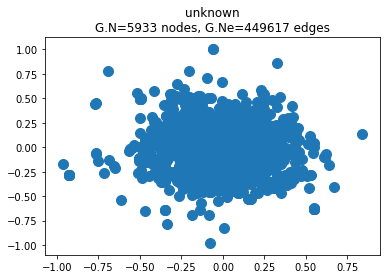

In [41]:
G.set_coordinates()
G.plot()

### Heat propagation on the graph starting from companies with high ROI

In [42]:
#Hyper-Parameters

TAU = 50 #heat diffusion constant
NB_START_COMPANIES = 5 #number of companies to start from in the heat diffusion
NUMBER_BEST_COMPANIES = 100
RISK = 1 #corresponds to how risk-prone we are. We kept 1 for the following, but we could test the results with a lower number.

We select the starting companies by taking the ones with the highest returns on investment:

Start companies: ['YouTube' 'Trusteer' 'Ask.com' 'Global Crossing' 'Omniture']


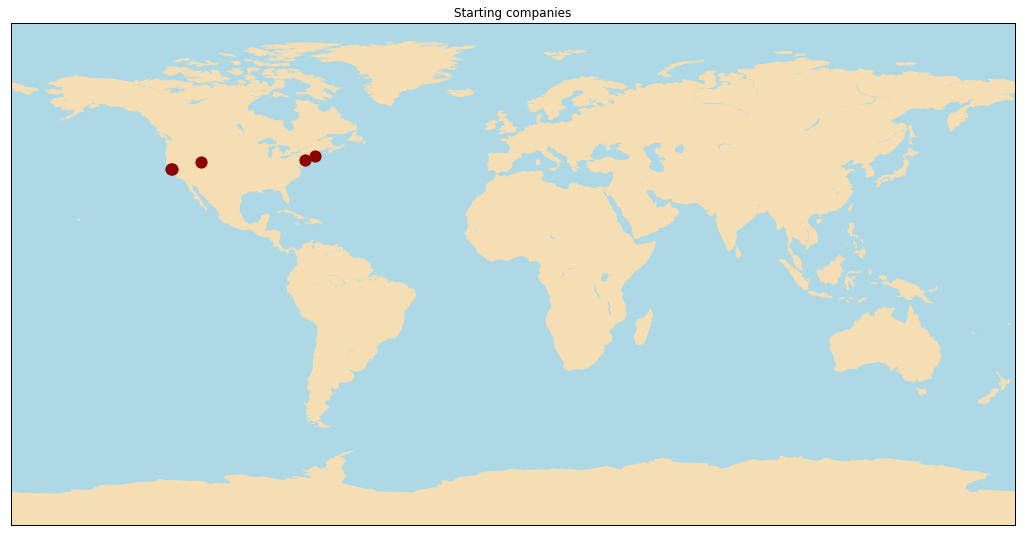

In [43]:
start_indices = np.flip(np.argsort(ROI_gc), 0)[:NB_START_COMPANIES]
start_companies = companies.loc[vertex_ids_gc[start_indices]]
print("Start companies: {}".format(start_companies["name"].values))
helpers.draw_map(start_companies["lat"], start_companies["lng"], title="Starting companies", size=500)

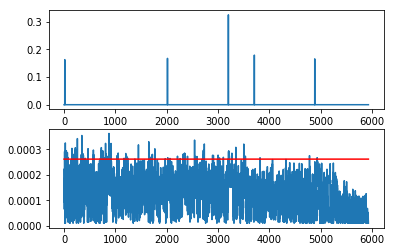

In [44]:
"""
We select the first one hundred companies with the biggest signal, they correspond to the values above the red line.
"""
company_indices = helpers.compute_companies(G, ROI_gc, start_indices, tau=TAU, nb_best_companies=NUMBER_BEST_COMPANIES)

We compute the ROI of each selected company. Companies that have status "ipo" have been introduced in the stock market. Hence, we use the Intrinio API to get the market valuation and compute a kind of "ROI".

In [45]:
multipliers, stats,  = helpers.compute_return_on_investment(company_indices, companies, vertex_ids_gc, ipos, risk=RISK)
return_on_investment = np.mean(np.array(multipliers))

print("Statistics: {}".format(stats))
print("Return on investment: {}".format(return_on_investment))

100%|██████████| 100/100 [00:01<00:00, 53.45it/s]

Statistics: {'acquired': 20, 'operating': 70, 'ipo': 9, 'closed': 1}
Return on investment: 3.24568810916


<div style="border: 1px black solid; padding: 10px; font-size: 1.2em;"><b>On average, our method enables to investors to have an ROI of over 3.2!</b></div>

In [46]:
status = companies["status"].value_counts().values
percentage = np.round(status / float(status.sum()) * 100, decimals=2)
stat_entire_dataset = {
    "operating": percentage[0],
    "acquired": percentage[1],
    "ipo": percentage[3],
    "closed": percentage[2]   
}
print("Statistics of the entire dataset (in %): {}".format(stat_entire_dataset))

Statistics of the entire dataset (in %): {'acquired': 4.78, 'operating': 93.33, 'ipo': 0.58, 'closed': 1.31}


We observe that among the selected companies, the acquired and ipo companies are over-represented compared to the entire dataset.


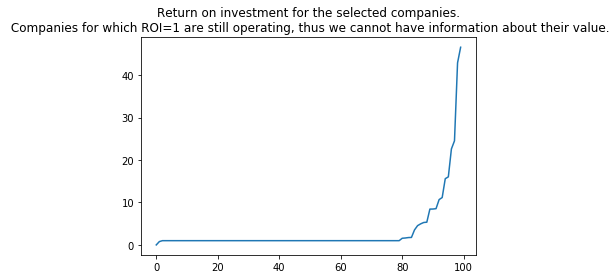

In [47]:
plt.title("Return on investment for the selected companies.\n Companies for which ROI=1 are still operating, thus we cannot have information about their value.")
plt.plot(np.sort(np.array(multipliers)));

### Plotting selected companies on a map

Printed below are the companies selected by our algorithm:

In [48]:
selected_companies = companies.loc[vertex_ids_gc[company_indices]]
print("Selected companies: {}".format(selected_companies["name"].values))

Selected companies: ['Dropcam' 'Gaikai' 'Domo' 'Bromium' 'Uber' 'Avnera' 'Box' 'Supernova'
 'Solarflare Communications' 'Facebook' 'KAYAK' 'Fab.com' 'Carrier IQ'
 'Dollar Shave Club' 'Prosper' 'LinkedIn' 'nanosys' 'Digital Chocolate'
 'Alta Devices' 'AdMob' 'Eons' 'Xoom Corporation' 'KupiVIP' 'Icera'
 'Eventbrite' 'Hearsay Social' 'XDx' 'Square' 'Flipboard' 'Bloom Energy'
 'Prism Skylabs' 'Stoke' 'StumbleUpon' 'The Climate Corporation'
 'Mint.com' 'Rockmelt' 'Gilt Groupe' 'Spotify' 'UberMedia' 'Dexterra'
 'Beceem Communications' 'OpenX' 'Houzz' 'Jawbone' 'Lookout' 'DocuSign'
 'Lending Club' 'Zynga' 'MongoDB, Inc.' 'Practice Fusion' 'CardioDx'
 'SpikeSource' 'Kno' 'Path' 'BuzzFeed' 'Twilio' 'Yammer' 'Zendesk'
 'Navini Networks' 'MySQL' 'Twitter' 'Big Switch Networks' 'FireEye'
 'Sosh' 'Opower' 'Zuora' 'BeachMint' 'betaworks' 'Dropbox'
 'Bump Technologies' 'Staccato Communications' 'Airbnb' 'Optimizely'
 'Aster Data Systems' 'Apperian' 'Codecademy' 'Stripe' '42Floors'
 'Groupon' 'Clever'

In [49]:
print("Funding total of Stripe: ${}".format(selected_companies.loc["c:71058"]["funding_total_usd"]))
print("Funding total of Dollar Shave Club: ${}".format(selected_companies.loc["c:151478"]["funding_total_usd"]))

Funding total of Stripe: $40000000.0
Funding total of Dollar Shave Club: $22800000.0


**Remark: **
This method enabled us to "discover" very valuable companies, such as :
* **Stripe** (which had raised "only" \$40 million back in 2013 and is now worth $9 billion [[link](http://fortune.com/2016/11/25/payments-stripe-valuation/)]).
* **Dollar Shave Club** (had raised "only" \$22 million in 2013 and has been acquired in 2016 for \$1 billion by Unilever [[link](https://techcrunch.com/2016/07/19/unilever-buys-dollar-shave-club-for-reported-1b-value/)]).

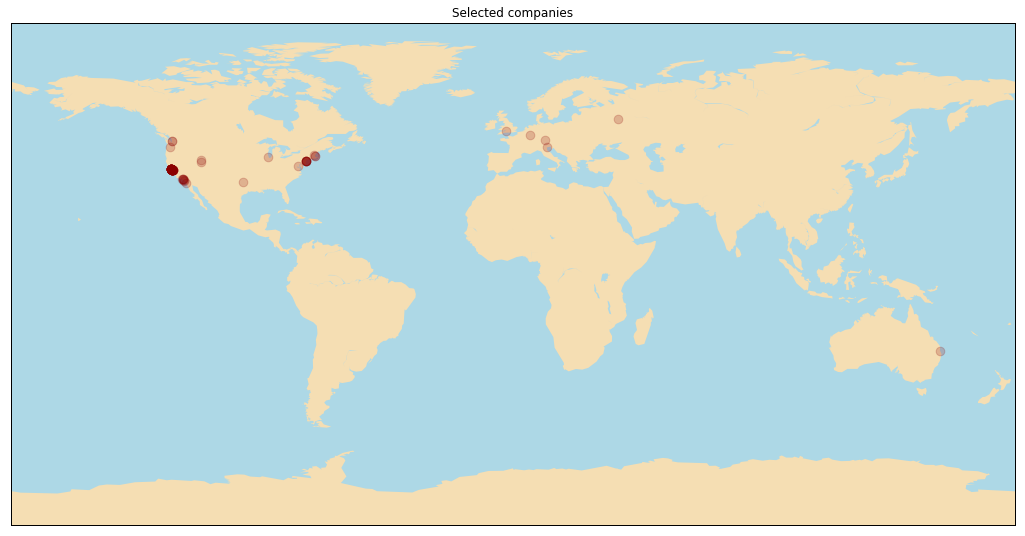

In [50]:
helpers.draw_map(selected_companies["lat"], selected_companies["lng"], title="Selected companies", size=300, alpha=0.2)

We observe that a majority of the selected companies are Silicon-Valley based.

### Displaying the selected companies on the graph

In [51]:
distanceMatrix = np.zeros((len(start_indices), len(company_indices)))

for i in range(NB_START_COMPANIES):
    for j in range(len(company_indices)):
        distanceMatrix[i, j] = graph_tool.topology.shortest_distance(g_gc, g_gc.vertex(start_indices[i]), g_gc.vertex(company_indices[j]))

In [52]:
vfilt = g_gc.new_vertex_property('bool');
vcolor = g_gc.new_vertex_property("string")

In [53]:
for vertex in g_gc.vertices():
    vcolor[vertex] = "#FFFFFF"
    
for company_index in start_indices:
    vfilt[g_gc.vertex(company_index)] = True
    vcolor[g_gc.vertex(company_index)] = "#FF3232"

for i, company_index in enumerate(company_indices):
    vfilt[g_gc.vertex(company_index)] = True
    
    if np.min(distanceMatrix[:, i]) == 1:
        vcolor[g_gc.vertex(company_index)] = "#96F423"
    else:
        vcolor[g_gc.vertex(company_index)] = "#EEFB5A"
        
for company_index in start_indices:
    for neighbor in g_gc.vertex(company_index).out_neighbors():
        vfilt[neighbor] = True

        if g_gc.vp.vertex_id[neighbor] not in selected_companies.index.values and g_gc.vp.vertex_id[neighbor] not in start_companies.index.values:
            vcolor[neighbor] = "#83D9F6"

In [54]:
sub = GraphView(g_gc, vfilt)

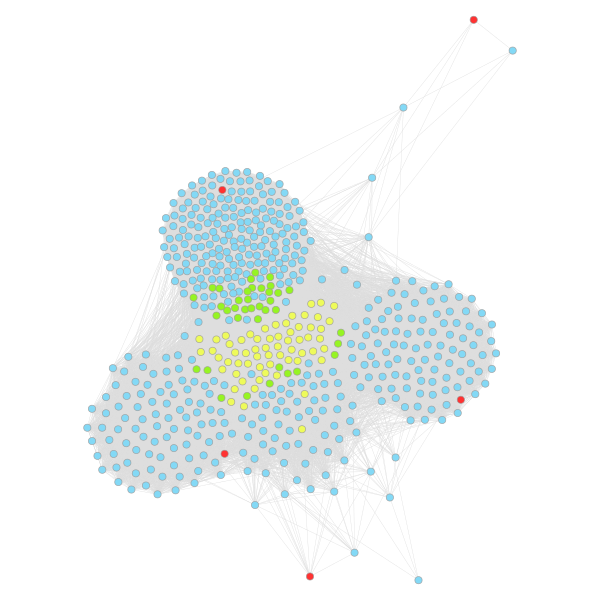

In [55]:
graph_draw(sub, vertex_fill_color=vcolor, edge_color="#DDDDDD", edge_pen_width=0.35);

This subgraph enables to visually understand how our initial signal "spreads". Notice that the graph is very densely connected. The color scheme is the following:
- red vertices correspond to starting companies;
- green vertices are selected companies that are direct neighbors to one of the starting companies;
- yellow vertices are selected companies at distance 2 from one of the starting comapanies;
- blue vertices are the direct neighbors of the starting companies but that have not been selected.

# Conclusion

The database we started with has only a few relevant features for the goal we strived to achieve, i.e. the total funding of a company, its investors and its return on investment (for the acquired companies). Not being able to build a similarity graph from those features, we ended up using a graph whose structure rises from common investors between companies. It appears to us as the main reason for the lack of results when applying the spectral analysis seen in class.

However, we thought that such a graph would be interesting to achieve our goal. The idea is that if an investor has invested in a successful company then it might have a good insight about the market. He is therefore likely to make other good investments. That's why we decided to use the Graph Fourier Transform. First, we select companies whose success is known (i.e. acquired with high return on investment). We can then start from a delta signal located on these vertices and propagate it on the graph. From a vertex, this signal will spread more towards its neighbors having a lot of common investors.

Looking at our results, this approach appears to be promising: the companies we select have a high return on investment on average. It has to be pondered with the fact that we worked with a snapshot of the market at a specific time.